<a href="https://colab.research.google.com/github/Adrianfc22/Final_Test_Vision/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import zipfile

Direction

In [14]:
data_dir = "/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

Libraries and transforms

In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import copy

import torch
import torch.nn as nn
import torchvision


from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets

import seaborn as sns

 
def transform_data(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

cuda:0


Model size

In [16]:

data_transforms = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform_data(x)) 
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(data_transforms[TRAIN], batch_size = 4, shuffle=True), 
               VAL: torch.utils.data.DataLoader(data_transforms[VAL], batch_size = 1, shuffle=True), 
               TEST: torch.utils.data.DataLoader(data_transforms[TEST], batch_size = 1, shuffle=True)}


dataset_sizes = {x: len(data_transforms[x]) for x in [TRAIN, VAL]}

print("Dataset sizes: ", dataset_sizes)
classes = data_transforms[TRAIN].classes
print("Dataset classes in TRAIN: ", classes)
classes = data_transforms[VAL].classes
print("Dataset classes in VAL: ", classes)

Dataset sizes:  {'train': 208, 'val': 18}
Dataset classes in TRAIN:  ['no', 'yes']
Dataset classes in VAL:  ['no', 'yes']


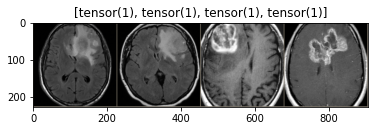

In [17]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes[x] for x in classes])

Vgg model

In [18]:
pretrained_model = models.vgg16(pretrained=True)
print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
for param in pretrained_model.features.parameters():
    param.required_grad = False


num_features_last_layer = pretrained_model.classifier[6].in_features
print("Num. of input nodes for the last fully-connected layer: ",num_features_last_layer)
classifier = list(pretrained_model.classifier.children())[:-1] 
print("Original classifier architecture:",classifier)

classifier.extend([nn.Linear(num_features_last_layer, len(classes))])
pretrained_model.classifier = nn.Sequential(*classifier) 
print("New classifier architecture",classifier)

Num. of input nodes for the last fully-connected layer:  4096
Original classifier architecture: [Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]
New classifier architecture [Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4, bias=True)]


In [20]:
import torch.optim as optim


pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [21]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Training

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        

        for phase in [TRAIN, VAL]:

            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            
            for data in dataloaders[phase]:
                images, labels = data
                
                images = images.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase==TRAIN):
                    
                    predicted = model(images)
                    _, preds = torch.max(predicted, 1)
                    loss = criterion(predicted, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * images.size(0)

                
                running_corrects += torch.sum(preds == labels.data)

            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

           
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    model.load_state_dict(best_model_weights)
    return model


n_epochs = 35

pretrained_model = train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/35
train Loss: 0.0521 Acc: 0.9856
val Loss: 0.3593 Acc: 0.8333
Epoch: 2/35
train Loss: 0.0424 Acc: 0.9952
val Loss: 0.3912 Acc: 0.8333
Epoch: 3/35
train Loss: 0.0488 Acc: 0.9904
val Loss: 0.4085 Acc: 0.8333
Epoch: 4/35
train Loss: 0.0440 Acc: 0.9904
val Loss: 0.4121 Acc: 0.7778
Epoch: 5/35
train Loss: 0.0441 Acc: 0.9952
val Loss: 0.4097 Acc: 0.8333
Epoch: 6/35
train Loss: 0.0433 Acc: 0.9952
val Loss: 0.4110 Acc: 0.7778
Epoch: 7/35
train Loss: 0.0411 Acc: 1.0000
val Loss: 0.4092 Acc: 0.8333
Epoch: 8/35
train Loss: 0.0417 Acc: 0.9952
val Loss: 0.4103 Acc: 0.8333
Epoch: 9/35
train Loss: 0.0459 Acc: 0.9952
val Loss: 0.4098 Acc: 0.8333
Epoch: 10/35
train Loss: 0.0337 Acc: 0.9952
val Loss: 0.4097 Acc: 0.8333
Epoch: 11/35
train Loss: 0.0382 Acc: 0.9904
val Loss: 0.4098 Acc: 0.8333
Epoch: 12/35
train Loss: 0.0426 Acc: 0.9952
val Loss: 0.4098 Acc: 0.8333
Epoch: 13/35
train Loss: 0.0459 Acc: 0.9856
val Loss: 0.4096 Acc: 0.8333
Epoch: 14/35
train Loss: 0.0397 Acc: 0.9952
val Loss: 0.4096

It can be seen that the training with Vgg, its accuracy is 1 and the loss is 0.054, showing that the training has a good accuracy and the validation has acceptable parameters, which is a good predictive model.

Model save

In [24]:
torch.save(pretrained_model, './my_model_35.pt') 

Model testing

In [25]:
def output_label(label):
    output_mapping = {
                 0: "No",
                 1: "Yes",
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  No, Yes, No, Yes, 

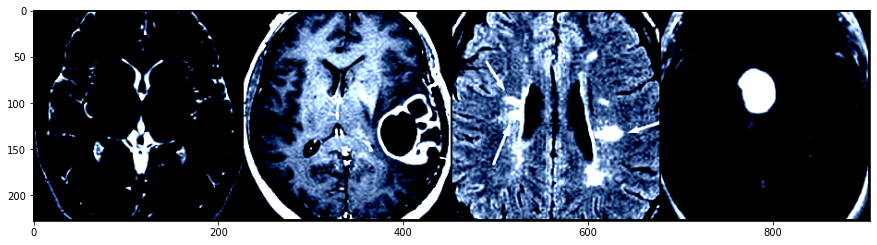

In [26]:
images, labels= next(iter(dataloaders[TRAIN]))
grid = torchvision.utils.make_grid(images, nrow=20)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

Resnet Model

In [27]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        
        for phase in [TRAIN, VAL]:

            
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                images, labels = data
                
                images = images.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase==TRAIN):
                    predicted = model(images)
                    _, preds = torch.max(predicted, 1)
                    loss = criterion(predicted, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)

                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
  
    model.load_state_dict(best_model_weights)
    return model


n_epochs = 35

resnet18 = train_model(resnet18, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/35
train Loss: 1.6783 Acc: 0.6923
val Loss: 0.4500 Acc: 0.8889
Epoch: 2/35
train Loss: 0.5038 Acc: 0.8413
val Loss: 2.2280 Acc: 0.5556
Epoch: 3/35
train Loss: 0.3395 Acc: 0.8894
val Loss: 0.4436 Acc: 0.7778
Epoch: 4/35
train Loss: 0.2590 Acc: 0.8990
val Loss: 0.8192 Acc: 0.7222
Epoch: 5/35
train Loss: 0.4524 Acc: 0.8798
val Loss: 0.4699 Acc: 0.8333
Epoch: 6/35
train Loss: 0.1749 Acc: 0.9567
val Loss: 0.7310 Acc: 0.7222
Epoch: 7/35
train Loss: 0.1843 Acc: 0.9327
val Loss: 0.5193 Acc: 0.8333
Epoch: 8/35
train Loss: 0.1552 Acc: 0.9567
val Loss: 0.6940 Acc: 0.7778
Epoch: 9/35
train Loss: 0.2604 Acc: 0.9327
val Loss: 1.1777 Acc: 0.7222
Epoch: 10/35
train Loss: 0.1082 Acc: 0.9663
val Loss: 0.4847 Acc: 0.7778
Epoch: 11/35
train Loss: 0.2269 Acc: 0.9375
val Loss: 0.6200 Acc: 0.7778
Epoch: 12/35
train Loss: 0.0453 Acc: 0.9856
val Loss: 0.3959 Acc: 0.8889
Epoch: 13/35
train Loss: 0.0454 Acc: 0.9856
val Loss: 0.4983 Acc: 0.8889
Epoch: 14/35
train Loss: 0.1583 Acc: 0.9615
val Loss: 0.5149

It can be seen that the training with Resnet, its accuracy is 1 and the loss is 0.0069, showing that the training has good accuracy and the validation has acceptable parameters similar to that of Vgg, which is a good predictive model compared to Vgg

Alexnet model

In [33]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [34]:
alexnet = alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [35]:
n_epochs = 35
pretrained_model = train_model(alexnet, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/35
train Loss: 1.9929 Acc: 0.5240
val Loss: 0.7690 Acc: 0.5556
Epoch: 2/35
train Loss: 1.3033 Acc: 0.5673
val Loss: 1.4023 Acc: 0.5556
Epoch: 3/35
train Loss: 1.4900 Acc: 0.5817
val Loss: 0.6422 Acc: 0.6111
Epoch: 4/35
train Loss: 0.6766 Acc: 0.6779
val Loss: 0.7183 Acc: 0.6667
Epoch: 5/35
train Loss: 0.7005 Acc: 0.6827
val Loss: 0.5208 Acc: 0.7222
Epoch: 6/35
train Loss: 0.4981 Acc: 0.8077
val Loss: 0.5413 Acc: 0.6667
Epoch: 7/35
train Loss: 0.4179 Acc: 0.8317
val Loss: 0.4245 Acc: 0.7778
Epoch: 8/35
train Loss: 0.2420 Acc: 0.9135
val Loss: 0.4604 Acc: 0.8889
Epoch: 9/35
train Loss: 0.1509 Acc: 0.9423
val Loss: 0.3979 Acc: 0.8333
Epoch: 10/35
train Loss: 0.0726 Acc: 0.9663
val Loss: 0.4879 Acc: 0.8333
Epoch: 11/35
train Loss: 0.0445 Acc: 0.9808
val Loss: 0.5555 Acc: 0.7222
Epoch: 12/35
train Loss: 0.0325 Acc: 0.9856
val Loss: 1.4425 Acc: 0.7222
Epoch: 13/35
train Loss: 0.0176 Acc: 0.9952
val Loss: 0.8810 Acc: 0.7222
Epoch: 14/35
train Loss: 0.0055 Acc: 1.0000
val Loss: 0.7611

In [ ]:
torch.save(pretrained_model, './my_model_35.pt') 

It can be seen that the training with Alexnet, its accuracy is 1 and the loss is 0.0018, showing that the training has a good precision and the validation has acceptable parameters, but with difference to the other models, its parameters are low, which is a good predictive model. almost equal to Resnet and better than Vgg

Squeezenet model

In [36]:
squeezenet = models.squeezenet1_0(pretrained=True)
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [37]:
squeezenet = squeezenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeezenet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [38]:
n_epochs = 35
pretrained_model = train_model(squeezenet, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/35
train Loss: 1.8157 Acc: 0.5433
val Loss: 0.8810 Acc: 0.4444
Epoch: 2/35
train Loss: 0.8497 Acc: 0.5481
val Loss: 0.7627 Acc: 0.5556
Epoch: 3/35
train Loss: 0.6780 Acc: 0.6298
val Loss: 0.8888 Acc: 0.5556
Epoch: 4/35
train Loss: 0.6404 Acc: 0.6538
val Loss: 0.7049 Acc: 0.6667
Epoch: 5/35
train Loss: 0.5518 Acc: 0.6731
val Loss: 0.9111 Acc: 0.6111
Epoch: 6/35
train Loss: 0.6662 Acc: 0.6731
val Loss: 0.6451 Acc: 0.6667
Epoch: 7/35
train Loss: 0.5519 Acc: 0.7260
val Loss: 0.7394 Acc: 0.6667
Epoch: 8/35
train Loss: 0.6065 Acc: 0.6779
val Loss: 0.6890 Acc: 0.4444
Epoch: 9/35
train Loss: 0.6652 Acc: 0.6442
val Loss: 0.6839 Acc: 0.6111
Epoch: 10/35
train Loss: 0.5499 Acc: 0.7308
val Loss: 0.6664 Acc: 0.6667
Epoch: 11/35
train Loss: 0.5444 Acc: 0.7500
val Loss: 0.7051 Acc: 0.6667
Epoch: 12/35
train Loss: 0.5251 Acc: 0.7308
val Loss: 0.9359 Acc: 0.4444
Epoch: 13/35
train Loss: 0.5561 Acc: 0.7500
val Loss: 0.6331 Acc: 0.7222
Epoch: 14/35
train Loss: 0.4677 Acc: 0.7692
val Loss: 0.5875

It can be seen that the training with squeezenet, its accuracy is 0.78 and the loss is 0.45, showing that the training has a less accuracy and the validation has very low parameters which this model does not have a good accuracy compared to the other models which not has a good accuracy and has a lot of loss in this model

Densenet Model

In [39]:
densenet = models.densenet161(pretrained=True)
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [40]:
densenet = densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [41]:
n_epochs = 35
pretrained_model = train_model(densenet, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/35
train Loss: 1.7143 Acc: 0.6827
val Loss: 1.1169 Acc: 0.6111
Epoch: 2/35
train Loss: 0.5845 Acc: 0.8173
val Loss: 0.6366 Acc: 0.7778
Epoch: 3/35
train Loss: 0.3168 Acc: 0.8558
val Loss: 1.2853 Acc: 0.6111
Epoch: 4/35
train Loss: 0.2198 Acc: 0.9135
val Loss: 0.7340 Acc: 0.7222
Epoch: 5/35
train Loss: 0.1553 Acc: 0.9327
val Loss: 0.3076 Acc: 0.8889
Epoch: 6/35
train Loss: 0.2283 Acc: 0.9423
val Loss: 0.4180 Acc: 0.8889
Epoch: 7/35
train Loss: 0.1877 Acc: 0.9567
val Loss: 0.4519 Acc: 0.8889
Epoch: 8/35
train Loss: 0.0866 Acc: 0.9712
val Loss: 0.4800 Acc: 0.8889
Epoch: 9/35
train Loss: 0.1817 Acc: 0.9663
val Loss: 0.2846 Acc: 0.8333
Epoch: 10/35
train Loss: 0.2247 Acc: 0.9375
val Loss: 0.4378 Acc: 0.8333
Epoch: 11/35
train Loss: 0.0376 Acc: 0.9904
val Loss: 0.5135 Acc: 0.8333
Epoch: 12/35
train Loss: 0.0164 Acc: 0.9952
val Loss: 0.5380 Acc: 0.8333
Epoch: 13/35
train Loss: 0.1076 Acc: 0.9808
val Loss: 0.6327 Acc: 0.7778
Epoch: 14/35
train Loss: 0.0388 Acc: 0.9904
val Loss: 0.5985

It can be seen that the training with densenet its accuracy is 0.9952 and the loss is 0.0112 showing that the training is good and the validation parameters show that it has a lot of data loss which this model is good but comparing to the Vgg models Resnet and Alexnet this model that gives below since the other models show better results

It can be seen that the training with Inception, its accuracy is 0.95 and the loss is 0.21, showing that the training is good and the validation parameters show acceptable but not good results, which, like densenet, are not good models for this project when compared to the models already seen before